In [1]:
import os
import sys
import json
import time
import copy
import torch
import random
import unittest
from unittest import TestCase
import logging
import warnings
import datetime
import torch.optim as opt

import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from sklearn import linear_model
import torch.nn.functional as F
from torch.autograd import grad, Variable
from torch.autograd.functional import vhp
from data_processing import get_data_adult
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

warnings.filterwarnings("ignore")
DEVICE = f"cuda:5"

EPOCH = 10
BATCH_SIZE = 100
NUM_A, NUM_B = 1, 7
WEIGHT_DECAY = 0.01
OUTPUT_DIR = 'result'
TEST_INDEX = 5
RECURSION_DEPTH = 1000
SAMPLE_NUM = 100
R = 10

plt.rcParams['figure.dpi'] = 300

### Utility Functions

In [2]:
def get_2class_mnist(num_a, num_b):
    train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
    x_train, y_train = train_data.data, train_data.targets

    test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))
    x_test, y_test = test_data.data, test_data.targets

    x_train, x_test = x_train.reshape([-1, 784]) / 255.0, x_test.reshape([-1, 784]) / 255.0
    x_train_2class, y_train_2class = from10to2classes(x_train, y_train, num_a, num_b)
    x_test_2class, y_test_2class = from10to2classes(x_test, y_test, num_a, num_b)

    return (x_train_2class, y_train_2class), (x_test_2class, y_test_2class)

In [3]:
def log_clip(x):
    return torch.log(torch.clamp(x, 1e-10, None))

In [4]:
def from10to2classes(x, y, num_a, num_b):
    is_num_a, is_num_b = y == num_a, y == num_b
    x_2class = np.concatenate([x[is_num_a], x[is_num_b]])
    y_2class = np.concatenate([np.ones(is_num_a.sum()), np.zeros(is_num_b.sum())]).reshape([-1, 1])

    return x_2class, y_2class

### Models

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, weight_decay):
        super(LogisticRegression, self).__init__()

        self.wd = torch.FloatTensor([weight_decay]).cuda()
        self.w = torch.nn.Parameter(torch.zeros([784], requires_grad=True))

    def forward(self, x):
        logits = torch.matmul(x, torch.reshape(self.w, [-1, 1]))

        return logits

    def loss(self, logits, y, train=True):
        preds = torch.sigmoid(logits)

        if train:
            loss = -torch.mean(y * log_clip(preds) + (1 - y) * log_clip(1 - preds)) # + torch.norm(self.w, 2) * self.wd
        else:
            loss = -torch.mean(y * log_clip(preds) + (1 - y) * log_clip(1 - preds))

        return loss

### Influence Calculation Functions


In [6]:
def calc_influence_single(
    model,
    train_loader,
    test_loader,
    test_id_num,
    gpu,
    recursion_depth,
    r,
    damp=0.01,
    scale=25,
    s_test_vec=None,
    time_logging=False,
    loss_func="cross_entropy",
):
    """Calculates the influences of all training data points on a single
    test dataset image.
    Arugments:
        model: pytorch model
        train_loader: DataLoader, loads the training dataset
        test_loader: DataLoader, loads the test dataset
        test_id_num: int, id of the test sample for which to calculate the
            influence function
        gpu: int, identifies the gpu id, -1 for cpu
        recursion_depth: int, number of recursions to perform during s_test
            calculation, increases accuracy. r*recursion_depth should equal the
            training dataset size.
        r: int, number of iterations of which to take the avg.
            of the h_estimate calculation; r*recursion_depth should equal the
            training dataset size.
        s_test_vec: list of torch tensor, contains s_test vectors. If left
            empty it will also be calculated
    Returns:
        influence: list of float, influences of all training data samples
            for one test sample
        harmful: list of float, influences sorted by harmfulness
        helpful: list of float, influences sorted by helpfulness
        test_id_num: int, the number of the test dataset point
            the influence was calculated for"""
    # Calculate s_test vectors if not provided
    if s_test_vec is None:
        z_test, t_test = test_loader.dataset[test_id_num]
        z_test = test_loader.collate_fn([z_test])
        t_test = test_loader.collate_fn([t_test])
        s_test_vec = s_test_sample(
            model,
            z_test,
            t_test,
            train_loader,
            gpu,
            recursion_depth=recursion_depth,
            r=r,
            damp=damp,
            scale=scale,
            loss_func=loss_func,
        )

    # Calculate the influence function
    train_dataset_size = len(train_loader.dataset)
    influences = []
    for i in tqdm(range(train_dataset_size)):
        z, t = train_loader.dataset[i]
        z = train_loader.collate_fn([z])
        t = train_loader.collate_fn([t])

        if time_logging:
            time_a = datetime.datetime.now()

        grad_z_vec = grad_z(z, t, model, gpu=gpu)

        if time_logging:
            time_b = datetime.datetime.now()
            time_delta = time_b - time_a
            logging.info(
                f"Time for grad_z iter:" f" {time_delta.total_seconds() * 1000}"
            )
        with torch.no_grad():
            tmp_influence = (
                -sum(
                    [
                        ####################
                        # TODO: potential bottle neck, takes 17% execution time
                        # torch.sum(k * j).data.cpu().numpy()
                        ####################
                        torch.sum(k * j).data
                        for k, j in zip(grad_z_vec, s_test_vec)
                    ]
                )
                / train_dataset_size
            )

        influences.append(tmp_influence)

    harmful = np.argsort([inf.cpu() for inf in influences])
    helpful = harmful[::-1]

    return influences, harmful.tolist(), helpful.tolist(), test_id_num

In [7]:
def s_test_sample(
    model,
    x_test,
    y_test,
    train_loader,
    gpu=-1,
    damp=0.01,
    scale=25,
    recursion_depth=5000,
    r=1,
    loss_func="cross_entropy",
):
    """Calculates s_test for a single test image taking into account the whole
    training dataset. s_test = invHessian * nabla(Loss(test_img, model params))
    Arguments:
        model: pytorch model, for which s_test should be calculated
        x_test: test image
        y_test: test image label
        train_loader: pytorch dataloader, which can load the train data
        gpu: int, device id to use for GPU, -1 for CPU (default)
        damp: float, influence function damping factor
        scale: float, influence calculation scaling factor
        recursion_depth: int, number of recursions to perform during s_test
            calculation, increases accuracy. r*recursion_depth should equal the
            training dataset size.
        r: int, number of iterations of which to take the avg.
            of the h_estimate calculation; r*recursion_depth should equal the
            training dataset size.
    Returns:
        s_test_vec: torch tensor, contains s_test for a single test image"""

    inverse_hvp = [
        torch.zeros_like(params, dtype=torch.float) for params in model.parameters()
    ]

    for i in range(r):

        hessian_loader = DataLoader(
            train_loader.dataset,
            sampler=torch.utils.data.RandomSampler(
                train_loader.dataset, True, num_samples=recursion_depth
            ),
            batch_size=1,
            num_workers=4,
        )

        cur_estimate = s_test(
            x_test, y_test, model, i, hessian_loader, gpu=gpu, damp=damp, scale=scale, loss_func=loss_func,
        )

        with torch.no_grad():
            inverse_hvp = [
                old + (cur / scale) for old, cur in zip(inverse_hvp, cur_estimate)
            ]

    with torch.no_grad():
        inverse_hvp = [component / r for component in inverse_hvp]

    return inverse_hvp

In [8]:
def grad_z(x, y, model, gpu=-1, loss_func="cross_entropy"):
    """Calculates the gradient z. One grad_z should be computed for each
    training sample.
    Arguments:
        x: torch tensor, training data points
            e.g. an image sample (batch_size, 3, 256, 256)
        y: torch tensor, training data labels
        model: torch NN, model used to evaluate the dataset
        gpu: int, device id to use for GPU, -1 for CPU
    Returns:
        grad_z: list of torch tensor, containing the gradients
            from model parameters to loss"""
    model.eval()

    # initialize
    if gpu >= 0:
        x, y = x.cuda(), y.cuda()

    prediction = model(x)

    loss = calc_loss(prediction, y, loss_func=loss_func)

    # Compute sum of gradients from model parameters to loss
    return grad(loss, model.parameters())

In [9]:
def s_test(x_test, y_test, model, i, samples_loader, gpu=-1, damp=0.01, scale=25.0, loss_func="cross_entropy"):
    """s_test can be precomputed for each test point of interest, and then
    multiplied with grad_z to get the desired value for each training point.
    Here, stochastic estimation is used to calculate s_test. s_test is the
    Inverse Hessian Vector Product.
    Arguments:
        x_test: torch tensor, test data points, such as test images
        y_test: torch tensor, contains all test data labels
        model: torch NN, model used to evaluate the dataset
        i: the sample number
        samples_loader: torch DataLoader, can load the training dataset
        gpu: int, GPU id to use if >=0 and -1 means use CPU
        damp: float, dampening factor
        scale: float, scaling factor
    Returns:
        h_estimate: list of torch tensors, s_test"""

    v = grad_z(x_test, y_test, model, gpu, loss_func=loss_func)
    h_estimate = v

    params, names = make_functional(model)
    # Make params regular Tensors instead of nn.Parameter
    params = tuple(p.detach().requires_grad_() for p in params)

    # TODO: Dynamically set the recursion depth so that iterations stop once h_estimate stabilises
    progress_bar = tqdm(samples_loader, desc=f"IHVP sample {i}")
    for i, (x_train, y_train) in enumerate(progress_bar):

        if gpu >= 0:
            x_train, y_train = x_train.cuda(), y_train.cuda()

        def f(*new_params):
            load_weights(model, names, new_params)
            out = model(x_train)
            loss = calc_loss(out, y_train, loss_func=loss_func)
            return loss

        hv = vhp(f, params, tuple(h_estimate), strict=True)[1]

        # Recursively calculate h_estimate
        with torch.no_grad():
            h_estimate = [
                _v + (1 - damp) * _h_e - _hv / scale
                for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]

            if i % 100 == 0:
                norm = sum([h_.norm() for h_ in h_estimate])
                progress_bar.set_postfix({"est_norm": norm.item()})

    with torch.no_grad():
        load_weights(model, names, params, as_params=True)

    return h_estimate


In [10]:
def calc_loss(logits, labels, loss_func="cross_entropy"):
    """Calculates the loss
    Arguments:
        logits: torch tensor, input with size (minibatch, nr_of_classes)
        labels: torch tensor, target expected by loss of size (0 to nr_of_classes-1)
        loss_func: str, specify loss function name
    Returns:
        loss: scalar, the loss"""
    
    if loss_func == "cross_entropy":
        if logits.shape[-1] == 1:
            loss = F.binary_cross_entropy_with_logits(logits, labels.type(torch.float))
        else:
            loss = F.cross_entropy(logits, labels)
    elif loss_func == "mean":
        loss = torch.mean(logits)
    else:
        raise ValueError("{} is not a valid value for loss_func".format(loss_func))

    return loss

In [11]:
def make_functional(model):
    orig_params = tuple(model.parameters())
    # Remove all the parameters in the model
    names = []

    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)

    return orig_params, names

In [12]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [13]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [14]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

### Perform Influence Calculation and LOO

In [15]:
class TestLeaveOneOut():
    def test_leave_one_out(self):

        gpus = 1 if torch.cuda.is_available() else 0

        (x_train, y_train), (x_test, y_test) = get_2class_mnist(NUM_A, NUM_B)
        train_sample_num = len(x_train)

        class CreateData(torch.utils.data.Dataset):
            def __init__(self, data, targets):
                self.data = data
                self.targets = targets

            def __len__(self):
                return len(self.data)

            def __getitem__(self, idx):
                out_data = self.data[idx]
                out_label = self.targets[idx]

                return out_data, out_label
        
        train_data = CreateData(x_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)

        # prepare sklearn model to train w
        C = 1.0 / (train_sample_num * WEIGHT_DECAY)
        sklearn_model = linear_model.LogisticRegression(C=C, solver='lbfgs', tol=1e-8, fit_intercept=False)

        # prepare pytorch model to compute influence function
        torch_model = LogisticRegression(weight_decay=WEIGHT_DECAY)

        # train
        sklearn_model.fit(x_train, y_train.ravel())
        print('LBFGS training took %s iter.' % sklearn_model.n_iter_)

        # assign W into pytorch model
        w_opt = sklearn_model.coef_.ravel()
        with torch.no_grad():
            torch_model.w = torch.nn.Parameter(
                torch.tensor(w_opt, dtype=torch.float)
            )
        
        # calculate original loss
        x_test_input = torch.FloatTensor(x_test[TEST_INDEX: TEST_INDEX+1])
        y_test_input = torch.LongTensor(y_test[TEST_INDEX: TEST_INDEX+1])

        test_data = CreateData(x_test[TEST_INDEX: TEST_INDEX+1], y_test[TEST_INDEX: TEST_INDEX+1])
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

        if gpus >= 0:
            torch_model = torch_model.cuda()
            x_test_input = x_test_input.cuda()
            y_test_input = y_test_input.cuda()

        test_loss_ori = torch_model.loss(torch_model(x_test_input), y_test_input, train=False).detach().cpu().numpy()

        loss_diff_approx, _, _, _, = calc_influence_single(torch_model, train_loader, test_loader, test_id_num=0, gpu=1,
                                    recursion_depth=RECURSION_DEPTH, r=R, damp=0)
        loss_diff_approx = - torch.FloatTensor(loss_diff_approx).cpu().numpy()

        # get high and low loss diff indice
        sorted_indice = np.argsort(loss_diff_approx)
        sample_indice = np.concatenate([sorted_indice[-int(SAMPLE_NUM/2):], sorted_indice[:int(SAMPLE_NUM/2)]])

        # calculate true loss diff
        loss_diff_true = np.zeros(SAMPLE_NUM)
        for i, index in zip(range(SAMPLE_NUM), sample_indice):
            print('[{}/{}]'.format(i+1, SAMPLE_NUM))

            # get minus one dataset
            x_train_minus_one = np.delete(x_train, index, axis=0)
            y_train_minus_one = np.delete(y_train, index, axis=0)

            # retrain
            C = 1.0 / ((train_sample_num - 1) * WEIGHT_DECAY)
            sklearn_model_minus_one = linear_model.LogisticRegression(C=C, fit_intercept=False, tol=1e-8, solver='lbfgs')
            sklearn_model_minus_one.fit(x_train_minus_one, y_train_minus_one.ravel())
            print('LBFGS training took {} iter.'.format(sklearn_model_minus_one.n_iter_))

            # assign w on tensorflow model
            w_retrain = sklearn_model_minus_one.coef_.T.ravel()
            with torch.no_grad():
                torch_model.w = torch.nn.Parameter(
                    torch.tensor(w_retrain, dtype=torch.float)
                )
            
            if gpus >= 0:
                torch_model = torch_model.cuda()

            # get retrain loss
            test_loss_retrain = torch_model.loss(torch_model(x_test_input), y_test_input, train=False).detach().cpu().numpy()

            # get true loss diff
            loss_diff_true[i] = test_loss_retrain - test_loss_ori

            print('Original loss       :{}'.format(test_loss_ori))
            print('Retrain loss        :{}'.format(test_loss_retrain))
            print('True loss diff      :{}'.format(loss_diff_true[i]))
            print('Estimated loss diff :{}'.format(loss_diff_approx[index]))

        r2_score = visualize_result(loss_diff_true, loss_diff_approx[sample_indice])

        self.assertTrue(r2_score > 0.9)

In [16]:
def visualize_result(actual_loss_diff, estimated_loss_diff):
    r2_s = r2_score(actual_loss_diff, estimated_loss_diff)

    max_abs = np.max([np.abs(actual_loss_diff), np.abs(estimated_loss_diff)])
    min_, max_ = -max_abs * 1.1, max_abs * 1.1
    plt.rcParams['figure.figsize'] = 6, 5
    plt.scatter(actual_loss_diff, estimated_loss_diff, zorder=2, s=10)
    plt.title('Loss diff')
    plt.xlabel('Actual loss diff')
    plt.ylabel('Estimated loss diff')
    range_ = [min_, max_]
    plt.plot(range_, range_, 'k-', alpha=0.2, zorder=1)
    text = 'MAE = {:.03}\nR2 score = {:.03}'.format(mean_absolute_error(actual_loss_diff, estimated_loss_diff),
                                                    r2_s)
    plt.text(max_abs, -max_abs, text, verticalalignment='bottom', horizontalalignment='right')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)

    plt.savefig("result.png")

    return r2_s

LBFGS training took [23] iter.


100%|███████████████████████████████████████████████████████████████████████████| 13007/13007 [00:06<00:00, 1917.20it/s]


[1/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.0170428603887558
True loss diff      :5.0380825996398926e-05
Estimated loss diff :3.298111550975591e-05
[2/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017035584896802902
True loss diff      :4.310533404350281e-05
Estimated loss diff :3.348308018757962e-05
[3/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017049772664904594
True loss diff      :5.729310214519501e-05
Estimated loss diff :3.3807165891630575e-05
[4/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.01703594997525215
True loss diff      :4.3470412492752075e-05
Estimated loss diff :3.384904994163662e-05
[5/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017031462863087654
True loss diff      :3.89833003282547e-05
Estimated

LBFGS training took [21] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.01707729883491993
True loss diff      :8.481927216053009e-05
Estimated loss diff :7.883675425546244e-05
[43/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017089728266000748
True loss diff      :9.724870324134827e-05
Estimated loss diff :8.081673149717972e-05
[44/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017114831134676933
True loss diff      :0.00012235157191753387
Estimated loss diff :8.502190030412748e-05
[45/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.017090093344449997
True loss diff      :9.761378169059753e-05
Estimated loss diff :8.913708006730303e-05
[46/100]
LBFGS training took [21] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.01707451045513153
True loss diff      :8.203089237213135e-05
Estimated los

LBFGS training took [21] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.016925854608416557
True loss diff      :-6.66249543428421e-05
Estimated loss diff :-7.53916974645108e-05
[83/100]
LBFGS training took [22] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.016900211572647095
True loss diff      :-9.226799011230469e-05
Estimated loss diff :-7.360712334048003e-05
[84/100]
LBFGS training took [22] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.01694870926439762
True loss diff      :-4.377029836177826e-05
Estimated loss diff :-7.28912273189053e-05
[85/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.016921792179346085
True loss diff      :-7.068738341331482e-05
Estimated loss diff :-7.229171751532704e-05
[86/100]
LBFGS training took [23] iter.
Original loss       :0.0169924795627594
Retrain loss        :0.01691003143787384
True loss diff      :-8.244812488555908e-05
Estimate

AttributeError: 'TestLeaveOneOut' object has no attribute 'assertTrue'

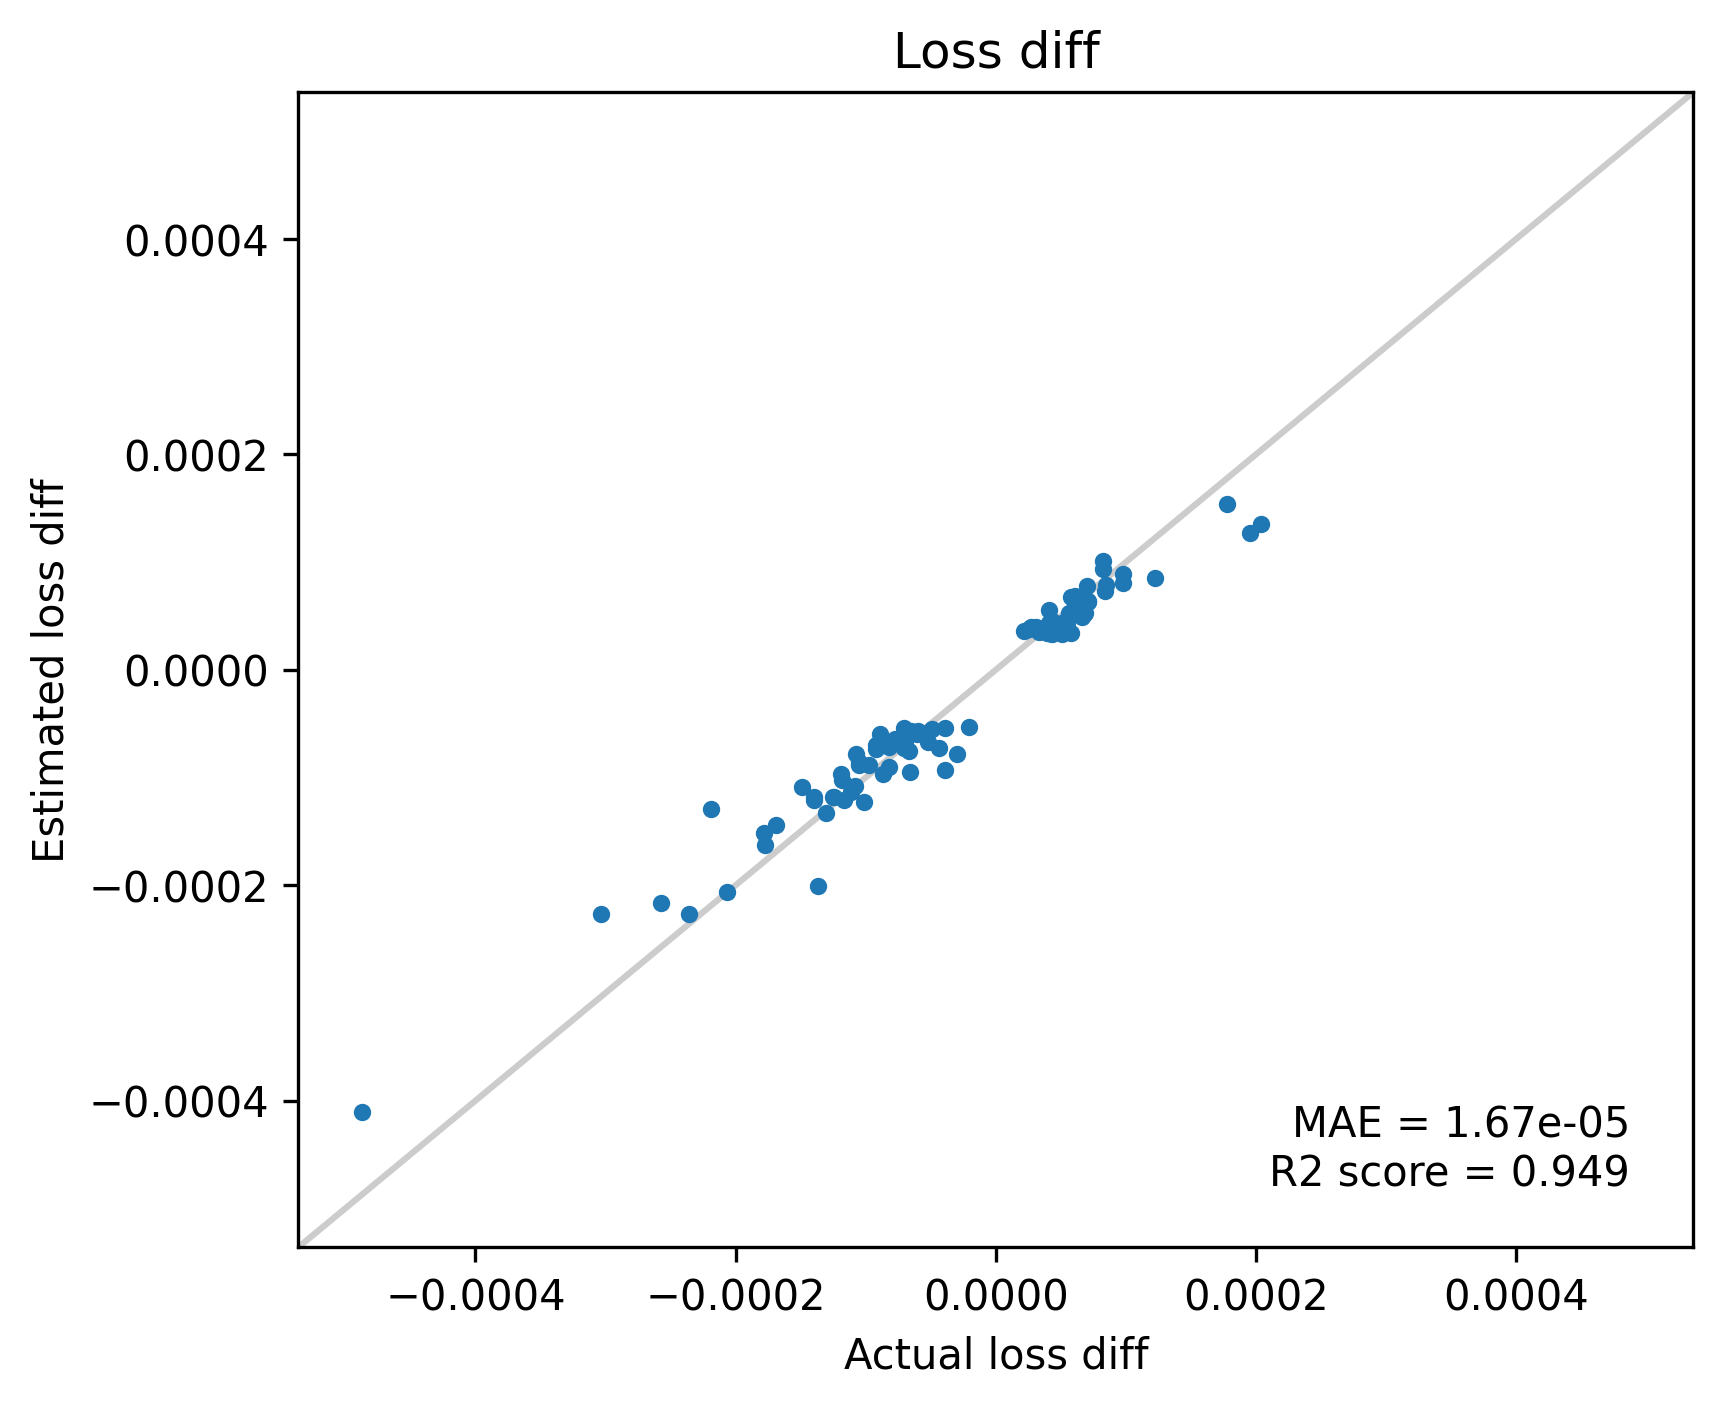

In [17]:
LOO = TestLeaveOneOut()
LOO.test_leave_one_out()